In [2]:
pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [3]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import random
import itertools
import copy
import os
import imp
import json

from scipy import interpolate
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from scipy.spatial import ConvexHull, convex_hull_plot_2d

import MissionScenario
import MissionPlan
import ZoningProblem
import utils

from sklearn.cluster import KMeans
from collections import defaultdict
from utils import *

imp.reload(utils)
imp.reload(MissionScenario)
imp.reload(ZoningProblem)
from MissionScenario import MissionScenario as Scenario
from ZoningProblem import ZoningSolution, ZoningAlgorithm, RoutingAlgorithm

hexcolours = ['#000000',
  '#6efa88',
  '#6ec7fa',
  '#f86efa',
  '#fac06e',
  '#fa6e6e',
  '#6efa88',
  '#6ec7fa',
  '#f86efa',
  '#fac06e',
  '#fa6e6e',
]

In [4]:
# scenario params
dist_start = 0#60000 #120000
dist_end = 0#-30000
nb_agents = 4
scenario_id = '1'

scenario = Scenario.generate(dist_base_centre=dist_start, dist_exit_centre=dist_end, \
                             nb_agents=nb_agents, nb_clusters=6)

for i in range(4):
  print(scenario.agents[i])

# important local vars
x = scenario.targets_x
y = scenario.targets_y
nb_targets = scenario.nb_targets
(xb, yb) = scenario.base
(xn, yn) = scenario.exit
(xe, ye) = scenario.centroid
print('centroid:', (xe, ye) )
Re = scenario.radius_internal
print('Internal radius:', Re)

{'name': 'UX', 'gravity_acc': 98.10000000000001, 'velocity': 1000, 'range-angle': 0.35, 'altitude': 5500}
{'name': 'typhoon', 'gravity_acc': 117.72, 'velocity': 693.0556, 'range-angle': 0.35, 'altitude': 7000}
{'name': 'G3', 'gravity_acc': 39.24, 'velocity': 450, 'range-angle': 0.7, 'altitude': 2500}
{'name': 'typhoon', 'gravity_acc': 117.72, 'velocity': 693.0556, 'range-angle': 0.35, 'altitude': 7000}
centroid: (36115.594696969696, 121249.95833333333)
Internal radius: 21867.31640618178


In [5]:
imp.reload(ZoningProblem)
from ZoningProblem import ZoningSolution, ZoningAlgorithm, RoutingAlgorithm
imp.reload(MissionScenario)
from MissionScenario import MissionScenario as Scenario
imp.reload(utils)
from utils import *

# generate zones
z_algo = ZoningAlgorithm(scenario)
[zoning_sol, envelope] = z_algo.search()

# generate routes
r_algo = RoutingAlgorithm(scenario)
[smooth_routes, routes, dropped_angles, routes_taskset] = r_algo.search()
print("dropped tasks/angles:", dropped_angles)


Iteration 2 - coverage: 54.00
dropped tasks/angles: []


In [6]:
targets = scenario.targets
for i in range(1, scenario.nb_agents+1):
  print('>>',routes_taskset[i-1])
  #print('  ', scenario.zoning_sol.zones[i])
  
  # for each potential task in the zone
  for task in scenario.zoning_sol.zones[i]:
    if task in routes_taskset[i-1]:
      continue
    for j in range(len(routes_taskset[i-1])-1):
      atask1 = routes_taskset[i-1][j]
      atask1_coord = targets[atask1]
      atask2 = routes_taskset[i-1][j+1]
      atask2_coord = targets[atask2]
      
      task_coord = targets[task]
      # distance between potential task and two adjacent tasks in route
      adj_dist = calc_distance(atask1_coord, task_coord) + calc_distance(atask2_coord, task_coord)
      #print(task, atask1,calc_distance(atask1_coord, task_coord), '|', \
      #      task, atask2,calc_distance(atask2_coord, task_coord))
      
  #print('\n')


>> [9, 13, 41, 92, 103, 138, 174, 202, 231]
>> [8, 27, 40, 81, 101, 144, 172, 201, 239, 258]
>> [24, 34, 88, 106, 142, 189, 205, 251, 257, 263]
>> [4, 16, 32, 78, 116, 151, 166, 227, 235, 260]


## Scenario and solution illustration

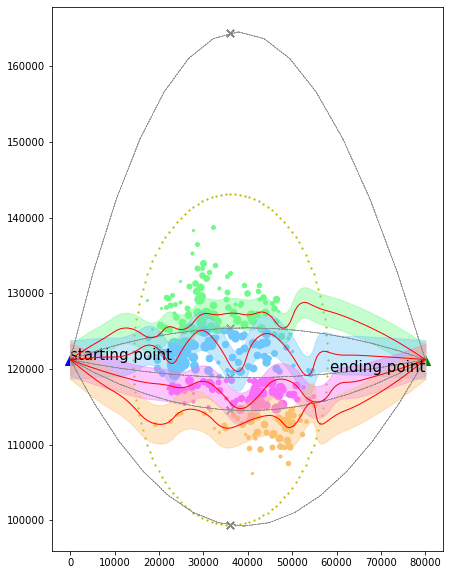

In [7]:
#=====================================
# PLOT SOLUTION:
#=====================================
#zoning_sol = scenario.zoning_sol
fig = plt.figure()
#fig.set_size_inches(9, 14)
fig.set_size_inches(7, 10)
ax = fig.add_subplot(111)

ax.grid(False)
# plot base station
ax.scatter(xb, yb, color='b', marker='^', s=100)
ax.text(xb, yb, 'starting point', size=15, zorder=1, color='k')
# plot next station
ax.scatter(xn, yn, color='g', marker='^', s=100)
ax.text(xn, yn, 'ending point', size=15, zorder=2, color='k', 
        horizontalalignment='right',verticalalignment='top',)

# sample points around safety circle:
for v in np.arange(0, 2*math.pi, math.pi/64.0):
  rnd = np.random.rand()
  theta = math.pi + v
  tx = xe + Re * math.cos(theta)
  ty = ye + Re * math.sin(theta)
  ax.scatter(tx, ty, color='y', marker='.', s=6)

nb_separators = scenario.nb_agents + 1

for i in range(nb_separators):
  for j in range(scenario.nb_wp):
    if zoning_sol.solution[j]==1:
      ax.scatter(scenario.sep_waypoints_x[j], scenario.sep_waypoints_y[j], color='#888', marker='x', s=50)
      # plot separators
      sep = zoning_sol.separators[i]

      for j in range(len(sep)-1):
        p1 = sep[j]
        p2 = sep[j+1]
        xline = (p1[0], p2[0])
        yline = (p1[1], p2[1])
        ax.plot(xline, yline, linestyle = '--', color='#888', linewidth=.5)

for zone_id, nodes in zoning_sol.zones.items():
  for node in nodes:
    p = scenario.priorities[node]
    ax.scatter(x[node], y[node], c=hexcolours[zone_id], s=p*5)
    #ax.text(x[node], y[node], node, size=6, color='#444')


# plot coverage envelope
#for line in envelope:
#  ax.plot([line[0][0],line[1][0]], [line[0][1],line[1][1]], c='#03a1fc')
#=====================================


#=====================================
# SHOW PATHS
#=====================================
for i in range(1, scenario.nb_agents+1):
  
  '''
  # plot original route
  cx, cy = zip(*routes[i-1])
  cx, cy = np.r_[cx], np.r_[cy]
  ax.plot(cx, cy, c='g', linewidth=1)
  '''

  # plot smoothed routes
  cx, cy = zip(*smooth_routes[i-1])
  cx, cy = np.r_[cx], np.r_[cy]
  ax.plot(cx, cy, c='r', linewidth=1)

for da in dropped_angles:
  print(da)
  ax.text(da[0][0], da[0][1], '%.2f'%da[1], size=12, zorder=1, color='k')
  ax.scatter(da[0][0], da[0][1], color='k', marker='x', s=50)

#zone_ids = scenario.zoning_sol.zones[i]
#for tid in task_IDs:
#  print(tid)

#zone = scenario.targets[scenario.zoning_sol.zones[1] ]
for i in range(1,nb_agents+1):
  zone_ids = scenario.zoning_sol.zones[i]
#=====================================


#=====================================
# PLOT EXPECTED COVERAGE
#=====================================
for i in range(scenario.nb_agents):
  profile = scenario.agents[i]
  A = profile['altitude']
  alpha = profile['range-angle']
  b = A*np.tan(alpha)
  colour = hexcolours[i+1]
  # plot original route
  cx, cy = zip(*smooth_routes[i])
  cx, cy = np.r_[cx], np.r_[cy]
  ax.fill_between(cx, cy-b, cy+b, alpha=0.4, color=colour)
#=====================================


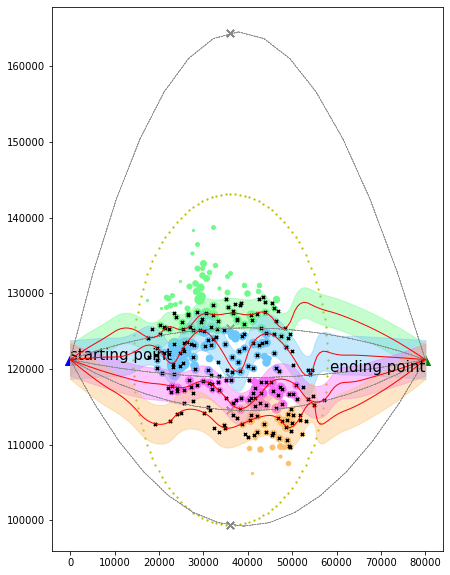

In [8]:
[acc_score, assigned_tasks] = r_algo.evaluate_route(smooth_routes)

#=====================================
# PLOT COVERED TASKS
#=====================================
for i in range(nb_targets):
  #print(assigned_tasks[i], end='/')
  if assigned_tasks[i]==1:
    ax.scatter(targets[i][0], targets[i][1], color='k', marker='x', s=10)
#=====================================
fig
#plt.show()
#fig.savefig('results/tmp-example.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)

Accumulated scores: 1919/2221
# task covered: 208/264
Range: 2555.1994638129718
[1, 2, 5, 6, 7, 8, 11, 12, 18, 25, 26, 27, 28, 38, 39, 40, 47, 48, 49, 50, 55, 62, 63, 64, 65, 80, 81, 89, 90, 91, 99, 100, 101, 108, 109, 114, 120, 121, 122, 127, 128, 129, 130, 136, 137, 144, 145, 146, 152, 153, 154, 162, 171, 172, 181, 182, 191, 198, 199, 200, 201, 206, 212, 213, 214, 224, 230, 239, 240, 247, 248, 249, 258, 259, 262]
[(17714, 121648), (17529, 124074), (19249, 121909), (19508, 120097), (19531, 121132), (19654, 122756), (20725, 119483), (21230, 122063), (22318, 121976), (23395, 119336), (23174, 120273), (23100, 120727), (23435, 123271), (24670, 120369), (24798, 122098), (25376, 122674), (25529, 120761), (25678, 122322), (25625, 123399), (26226, 123555), (27222, 123278), (28049, 120008), (27840, 120561), (27630, 121609), (27972, 123154), (30307, 123080), (30262, 125033), (31037, 119889), (31330, 121491), (31033, 123835), (31746, 119180), (31797, 123186), (32264, 124003), (33272, 120864), (3

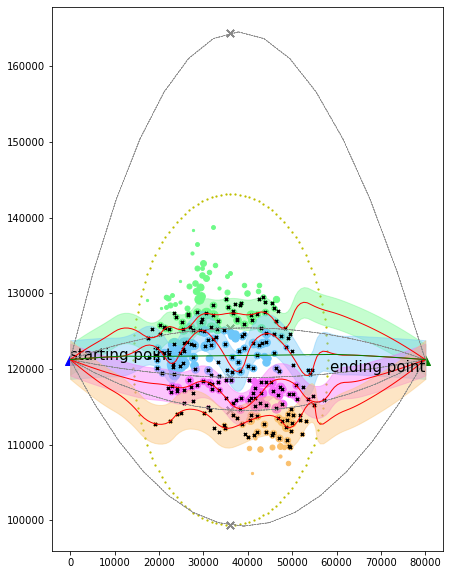

In [9]:
##============================
## IMPROVED ROUTING
##============================

print('Accumulated scores:', str(acc_score)+'/'+str(sum(scenario.priorities)) )
print('# task covered:', str(sum(assigned_tasks))+'/'+str(nb_targets))

profile = scenario.agents[1]

b = profile['altitude']*np.tan(profile['range-angle'])
print('Range:', b)

i = 1
route = routes[i]
zone_tasks = scenario.zoning_sol.zones[i+1]
print(zone_tasks)
print([targets[i] for i in zone_tasks])


# calculate distance between route (set of segments) and task
changeable_nodes = []
for k in range(1, len(route)-1):
  j_min = 0
  for j in range(nb_targets):
    if calc_distance(route[k], targets[j]) < calc_distance(route[k], targets[j_min]):
      #print( route[k], '|', targets[j], ':', round(calc_distance_pl(targets[j], [route[k], route[k+1]])) )
      j_min = j
  if calc_distance(route[k], targets[j_min])<=b:
    changeable_nodes.append(k)
print(changeable_nodes)

for k in changeable_nodes:
  j_min = 0
  dist_min = math.inf

  for j in zone_tasks:
    #if assigned_tasks[j]==1:
    #  print(j,'already assigned')
    #  continue
    
    #if target in zone??
    if calc_distance(route[k], targets[j]) < dist_min and calc_distance(route[k], targets[j])>0.1:
      #print(j, targets[j])
      dist_min = calc_distance(route[k], targets[j])
      j_min = j
      break
  print(k, '>> ', route[k], targets[j_min], calc_distance(route[k], targets[j_min]) )
  # swap tasks
  route[k] = targets[j_min]





#=====================================
# SHOW PATHS
#=====================================
# plot updated route
cx, cy = zip(*routes[i])
cx, cy = np.r_[cx], np.r_[cy]
ax.plot(cx, cy, c='g', linewidth=1)

fig
#plt.show()

# UPDATED FIGURE AND TASK COVERED

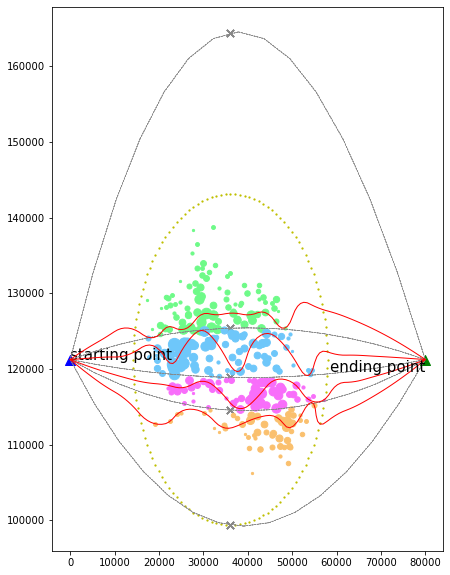

In [169]:
#=====================================
# PLOT SOLUTION:
#=====================================
#zoning_sol = scenario.zoning_sol
fig = plt.figure()
#fig.set_size_inches(9, 14)
fig.set_size_inches(7, 10)
ax = fig.add_subplot(111)

ax.grid(False)
# plot base station
ax.scatter(xb, yb, color='b', marker='^', s=100)
ax.text(xb, yb, 'starting point', size=15, zorder=1, color='k')
# plot next station
ax.scatter(xn, yn, color='g', marker='^', s=100)
ax.text(xn, yn, 'ending point', size=15, zorder=2, color='k', 
        horizontalalignment='right',verticalalignment='top',)

# sample points around safety circle:
for v in np.arange(0, 2*math.pi, math.pi/64.0):
  rnd = np.random.rand()
  theta = math.pi + v
  tx = xe + Re * math.cos(theta)
  ty = ye + Re * math.sin(theta)
  ax.scatter(tx, ty, color='y', marker='.', s=6)

nb_separators = scenario.nb_agents + 1

for i in range(nb_separators):
  for j in range(scenario.nb_wp):
    if zoning_sol.solution[j]==1:
      ax.scatter(scenario.sep_waypoints_x[j], scenario.sep_waypoints_y[j], color='#888', marker='x', s=50)
      # plot separators
      sep = zoning_sol.separators[i]

      for j in range(len(sep)-1):
        p1 = sep[j]
        p2 = sep[j+1]
        xline = (p1[0], p2[0])
        yline = (p1[1], p2[1])
        ax.plot(xline, yline, linestyle = '--', color='#888', linewidth=.5)

for zone_id, nodes in zoning_sol.zones.items():
  for node in nodes:
    p = scenario.priorities[node]
    ax.scatter(x[node], y[node], c=hexcolours[zone_id], s=p*5)
    #ax.text(x[node], y[node], node, size=6, color='#444')


# plot coverage envelope
#for line in envelope:
#  ax.plot([line[0][0],line[1][0]], [line[0][1],line[1][1]], c='#03a1fc')
#=====================================


#=====================================
# SHOW PATHS
#=====================================
for i in range(1, scenario.nb_agents+1):
  
  '''
  # plot original route
  cx, cy = zip(*routes[i-1])
  cx, cy = np.r_[cx], np.r_[cy]
  ax.plot(cx, cy, c='g', linewidth=1)
  '''

  # plot smoothed routes
  cx, cy = zip(*smooth_routes[i-1])
  cx, cy = np.r_[cx], np.r_[cy]
  ax.plot(cx, cy, c='r', linewidth=1)

for da in dropped_angles:
  print(da)
  ax.text(da[0][0], da[0][1], '%.2f'%da[1], size=12, zorder=1, color='k')
  ax.scatter(da[0][0], da[0][1], color='k', marker='x', s=50)

#zone_ids = scenario.zoning_sol.zones[i]
#for tid in task_IDs:
#  print(tid)

#zone = scenario.targets[scenario.zoning_sol.zones[1] ]
for i in range(1,nb_agents+1):
  zone_ids = scenario.zoning_sol.zones[i]
#=====================================

In [ ]:
# Updated turn_radius
#https://www.mathematicalway.com/mathematics/geometry/altitude-triangle/
# Bank angle: Positive means to the left

turn_radius_dct = {}
bank_angle_dct = {}
coverage_dct_right = {}
coverage_dct_left = {}

for i in range(scenario.nb_agents):
    profile = scenario.agents[i]
    nb_nodes = len(smooth_routes[i])
    A = profile['altitude']
    alpha = profile['range-angle']
    turn_radius_dct['agent_%s' % i] = []
    bank_angle_dct['agent_%s' % i] = []
    coverage_dct_right['agent_%s' % i] = []
    coverage_dct_left['agent_%s' % i] = []
    for j in range(nb_nodes-2):
        a = calc_distance(smooth_routes[i][j],smooth_routes[i][j+1])
        b = calc_distance(smooth_routes[i][j+1],smooth_routes[i][j+2])
        c = calc_distance(smooth_routes[i][j],smooth_routes[i][j+2])
        s = (a+b+c)/2
        w = math.sqrt(s*(s-a)*(s-b)*(s-c))
        turn_radius = (2*w) / c
        turn_radius_dct['agent_%s' % i].append(turn_radius)
        bank_angle = calc_phi(profile['velocity'], turn_radius, profile['gravity_acc'])
        bank_angle_dct['agent_%s' % i].append(bank_angle)

In [170]:
# Bank angle: Positive means to the left

turn_radius_dct = {}
bank_angle_dct = {}
coverage_dct_right = {}
coverage_dct_left = {}

for i in range(scenario.nb_agents):
    profile = scenario.agents[i]
    nb_nodes = len(smooth_routes[i])
    A = profile['altitude']
    alpha = profile['range-angle']
    turn_radius_dct['agent_%s' % i] = []
    bank_angle_dct['agent_%s' % i] = []
    coverage_dct_right['agent_%s' % i] = []
    coverage_dct_left['agent_%s' % i] = []
    for j in range(nb_nodes-2):
        a = calc_distance(smooth_routes[i][j],smooth_routes[i][j+1])
        b = calc_distance(smooth_routes[i][j+1],smooth_routes[i][j+2])
        turn_radius = a+b
        turn_radius_dct['agent_%s' % i].append(turn_radius)
        bank_angle = calc_phi(profile['velocity'], turn_radius, profile['gravity_acc'])
        bank_angle_dct['agent_%s' % i].append(bank_angle)
        bank_angle_in_radian = math.radians(bank_angle)
        b1 = A*np.tan(alpha-bank_angle_in_radian) # for left
        b2 = A*np.tan(alpha+bank_angle_in_radian) # for right
        coverage_dct_right['agent_%s' % i].append(b2)
        coverage_dct_left['agent_%s' % i].append(b1)

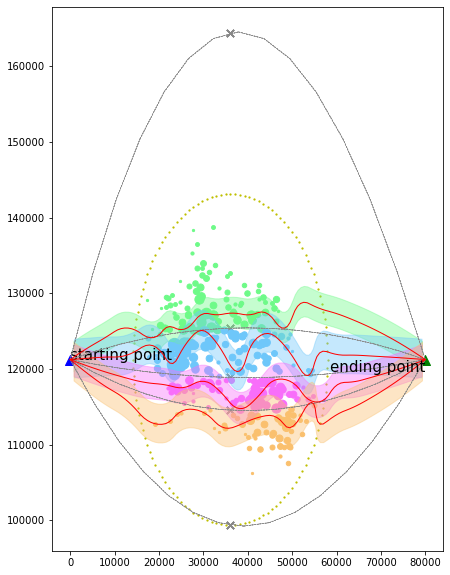

In [171]:
#=====================================
# PLOT SOLUTION:
#=====================================
#zoning_sol = scenario.zoning_sol
fig = plt.figure()
#fig.set_size_inches(9, 14)
fig.set_size_inches(7, 10)
ax = fig.add_subplot(111)

ax.grid(False)
# plot base station
ax.scatter(xb, yb, color='b', marker='^', s=100)
ax.text(xb, yb, 'starting point', size=15, zorder=1, color='k')
# plot next station
ax.scatter(xn, yn, color='g', marker='^', s=100)
ax.text(xn, yn, 'ending point', size=15, zorder=2, color='k', 
        horizontalalignment='right',verticalalignment='top',)

# sample points around safety circle:
for v in np.arange(0, 2*math.pi, math.pi/64.0):
  rnd = np.random.rand()
  theta = math.pi + v
  tx = xe + Re * math.cos(theta)
  ty = ye + Re * math.sin(theta)
  ax.scatter(tx, ty, color='y', marker='.', s=6)

nb_separators = scenario.nb_agents + 1

for i in range(nb_separators):
  for j in range(scenario.nb_wp):
    if zoning_sol.solution[j]==1:
      ax.scatter(scenario.sep_waypoints_x[j], scenario.sep_waypoints_y[j], color='#888', marker='x', s=50)
      # plot separators
      sep = zoning_sol.separators[i]

      for j in range(len(sep)-1):
        p1 = sep[j]
        p2 = sep[j+1]
        xline = (p1[0], p2[0])
        yline = (p1[1], p2[1])
        ax.plot(xline, yline, linestyle = '--', color='#888', linewidth=.5)

for zone_id, nodes in zoning_sol.zones.items():
  for node in nodes:
    p = scenario.priorities[node]
    ax.scatter(x[node], y[node], c=hexcolours[zone_id], s=p*5)
    #ax.text(x[node], y[node], node, size=6, color='#444')


# plot coverage envelope
#for line in envelope:
#  ax.plot([line[0][0],line[1][0]], [line[0][1],line[1][1]], c='#03a1fc')
#=====================================


#=====================================
# SHOW PATHS
#=====================================
for i in range(1, scenario.nb_agents+1):
  
  '''
  # plot original route
  cx, cy = zip(*routes[i-1])
  cx, cy = np.r_[cx], np.r_[cy]
  ax.plot(cx, cy, c='g', linewidth=1)
  '''

  # plot smoothed routes
  cx, cy = zip(*smooth_routes[i-1])
  cx, cy = np.r_[cx], np.r_[cy]
  ax.plot(cx, cy, c='r', linewidth=1)

for da in dropped_angles:
  print(da)
  ax.text(da[0][0], da[0][1], '%.2f'%da[1], size=12, zorder=1, color='k')
  ax.scatter(da[0][0], da[0][1], color='k', marker='x', s=50)

#zone_ids = scenario.zoning_sol.zones[i]
#for tid in task_IDs:
#  print(tid)

#zone = scenario.targets[scenario.zoning_sol.zones[1] ]
for i in range(1,nb_agents+1):
  zone_ids = scenario.zoning_sol.zones[i]
#=====================================

#=====================================
# PLOT EXPECTED COVERAGE
#=====================================
for i in range(scenario.nb_agents):
  #profile = scenario.agents[i]
  #A = profile['altitude']
  #alpha = profile['range-angle']
  #b = A*np.tan(alpha)
  colour = hexcolours[i+1]
  # plot original route
  aaa, bbb = zip(*smooth_routes[i])
  aaa = aaa[1:-1]
  bbb = bbb[1:-1]
  aaa, bbb = np.r_[aaa], np.r_[bbb]
  ax.fill_between(aaa, bbb-coverage_dct_left['agent_%s' % i], bbb+coverage_dct_right['agent_%s' % i], alpha=0.4, color=colour)
#=====================================

In [174]:
acc_score

1627

In [175]:
len(scenario.targets)

264

In [176]:
assigned_tasks

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

## Updated Coverage Scores

In [214]:
nb_targets = len(scenario.targets)
assigned_tasks = np.zeros(nb_targets, dtype=int)
length_corridor = len(coverage_dct_right['agent_0'])
#print(assigned_tasks)
for i in range(scenario.nb_agents):
    corridor_dct['agent_%s' % i] = []
    list_of_number_for_polygon_1 = []
    list_of_number_for_polygon_2 = []
    #all_poly = []
    coord_1, coord_2 = zip(*smooth_routes[i])
    coord_1 = coord_1[1:-1]
    coord_2 = coord_2[1:-1]
    for j in range(length_corridor):
        pairwise_points_1 = []
        pairwise_points_2 = []
        pairwise_points_1.append(coord_1[length_corridor-j-1])
        pairwise_points_1.append(coord_2[length_corridor-j-1]-coverage_dct_left['agent_%s' % i][length_corridor-j-1])
        pairwise_points_2.append(coord_1[j])
        pairwise_points_2.append(coord_2[j]+coverage_dct_right['agent_%s' % i][j])
        list_of_number_for_polygon_2.append(pairwise_points_2)
        list_of_number_for_polygon_1.append(pairwise_points_1)
    corridor_dct['agent_%s' % i].append(list_of_number_for_polygon_2)
    corridor_dct['agent_%s' % i].append(list_of_number_for_polygon_1)
    all_poly = list_of_number_for_polygon_2 + list_of_number_for_polygon_1
    polygon = Polygon(all_poly)
    for k in range(nb_targets):
        if polygon.contains(Point(scenario.targets[k])):
        #ax.scatter(targets[j][0], targets[j][1], color='k', marker='x', s=20)
            assigned_tasks[k] = 1
            #break

    #=====================================
    #for i in range(nb_targets):
    #  print(i,assigned_tasks[i],end=' | ')
    #print()
    #print(sum(assigned_tasks),'/',nb_targets)

acc_score = sum([scenario.priorities[i]*assigned_tasks[i] for i in range(nb_targets)])

In [216]:
print('Accumulated scores:', str(acc_score)+'/'+str(sum(scenario.priorities)) )
print('# task covered:', str(sum(assigned_tasks))+'/'+str(nb_targets))

Accumulated scores: 1831/2221
# task covered: 196/264


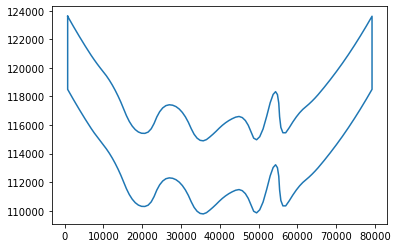

In [215]:
plt.plot(*polygon.exterior.xy)

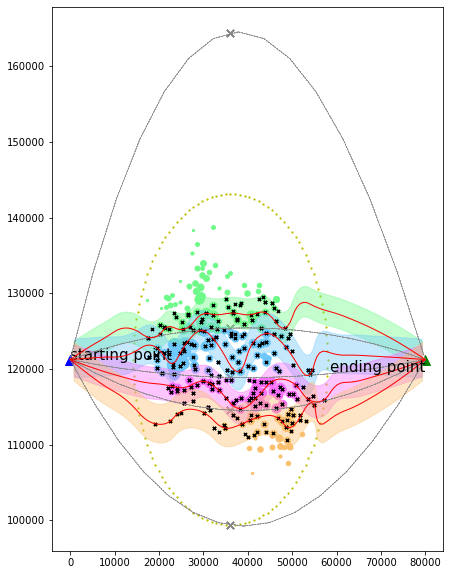

In [217]:
#=====================================
# PLOT COVERED TASKS
#=====================================
for i in range(nb_targets):
  #print(assigned_tasks[i], end='/')
  if assigned_tasks[i]==1:
    ax.scatter(targets[i][0], targets[i][1], color='k', marker='x', s=10)
#=====================================
fig
#plt.show()
#fig.savefig('results/tmp-example.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)

In [203]:
for i in range(length_corridor):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
